# Imports

In [253]:
!pip install pandas numpy matplotlib seaborn scikit-learn
!pip install xgboost

In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import joblib

import warnings
warnings.filterwarnings('ignore')

In [255]:
base_dir = os.path.dirname(os.path.abspath("__file__"))  # Current working directory
data_path = os.path.join(base_dir, "..", "data", "Student_performance_data .csv")
df = pd.read_csv(data_path)

df.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


# Feature Engineering

In [256]:
# 1. Engagement Index (sum of extracurricular activities)
df['EngagementIndex'] = df['Extracurricular'] + df['Sports'] + df['Music'] + df['Volunteering']

# 2. Attendance Rate (assuming standard 180-day school year)
school_days = 180
df['AttendanceRate'] = np.clip((school_days - df['Absences']) / school_days * 100, 0, 100)

In [257]:
df.EngagementIndex.unique()

array([1, 0, 2, 3, 4], dtype=int64)

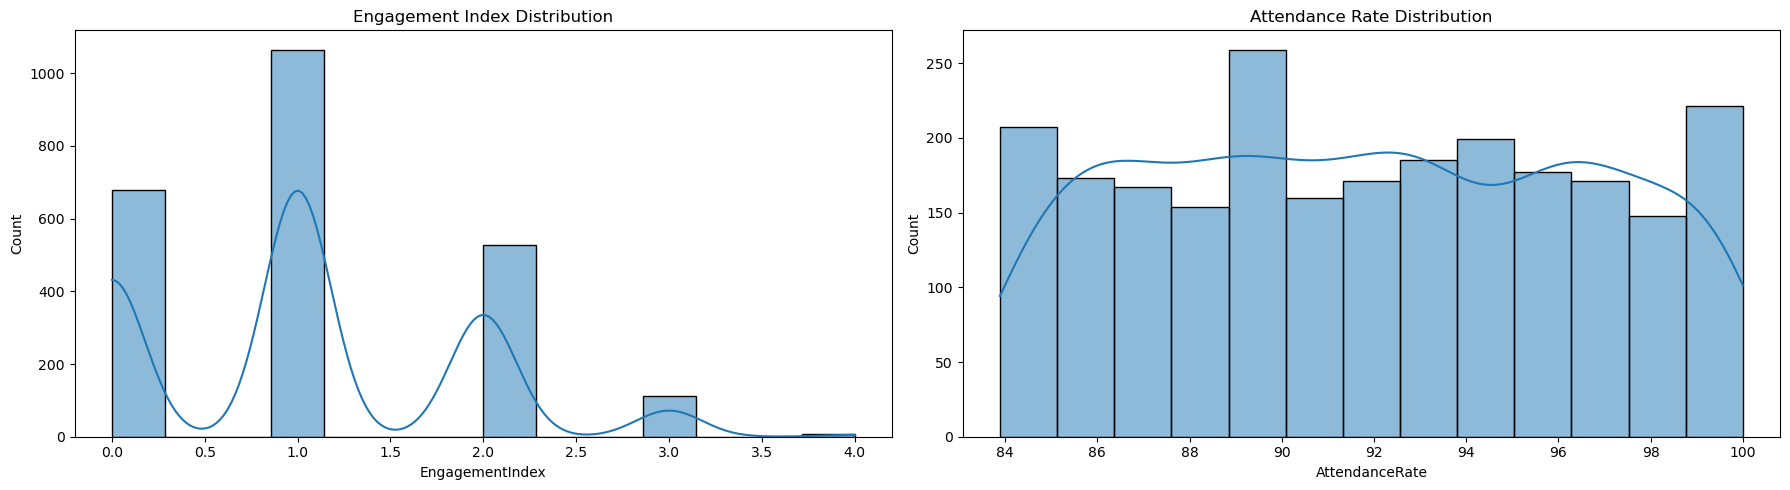

In [258]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.histplot(df['EngagementIndex'], kde=True, ax=axes[0])
axes[0].set_title('Engagement Index Distribution')

sns.histplot(df['AttendanceRate'], kde=True, ax=axes[1])
axes[1].set_title('Attendance Rate Distribution')

plt.tight_layout()
plt.show()

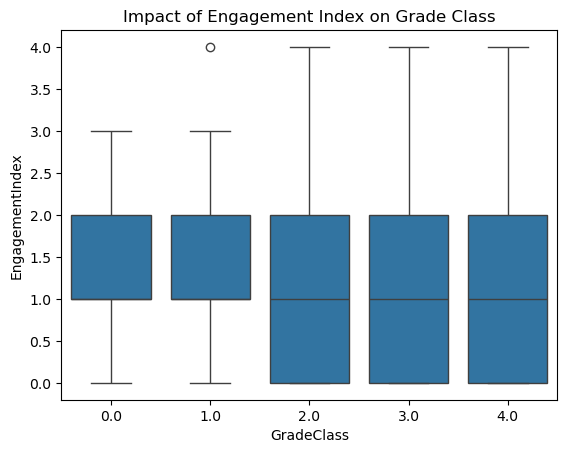

In [259]:
sns.boxplot(y='EngagementIndex', x='GradeClass', data=df)
plt.title('Impact of Engagement Index on Grade Class')
plt.show()

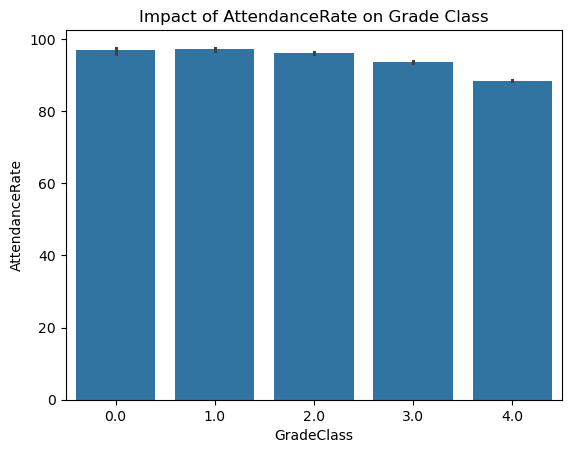

In [260]:
sns.barplot(y='AttendanceRate', x='GradeClass', data=df)
plt.title('Impact of AttendanceRate on Grade Class')
plt.show()

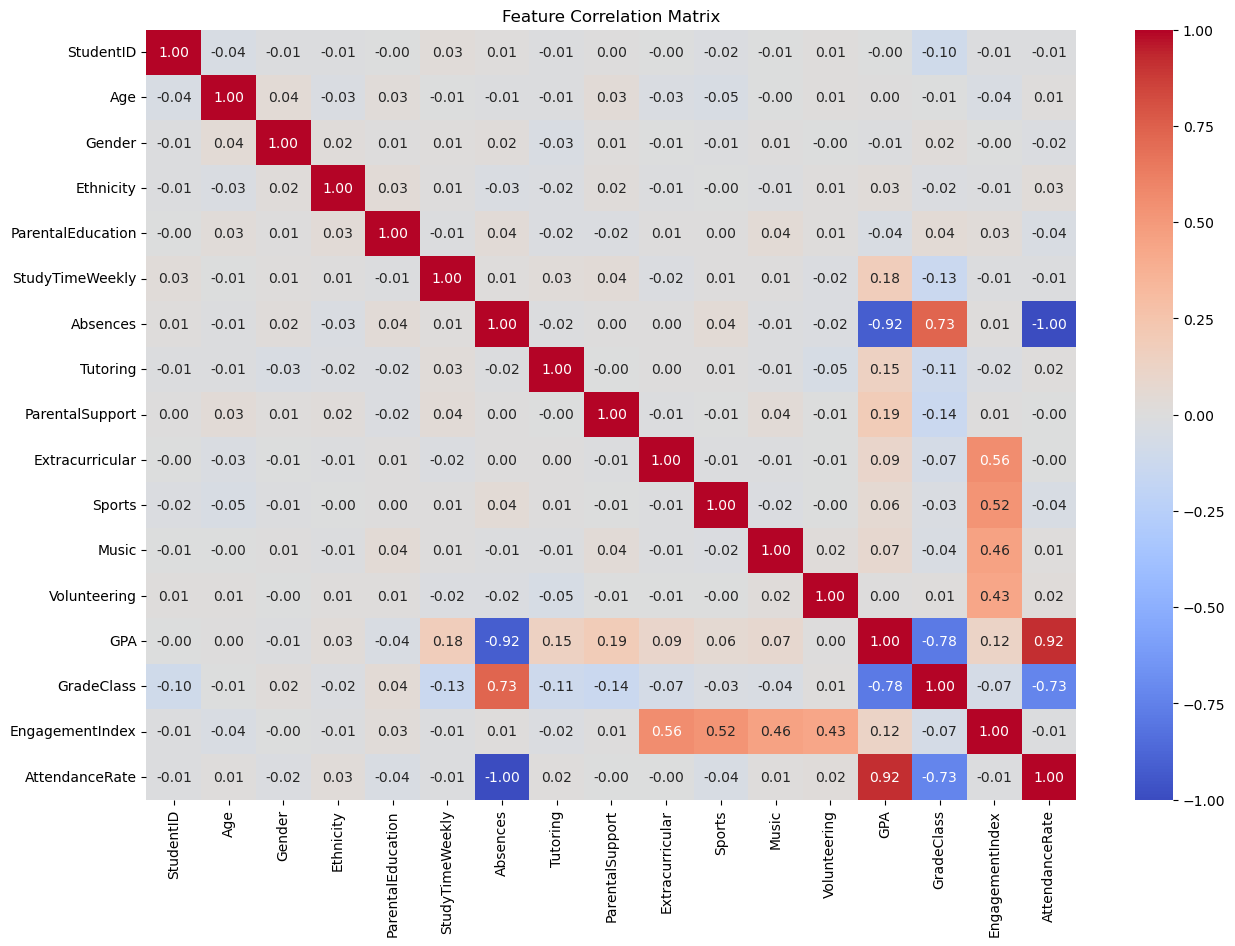

In [261]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [262]:
df = df.drop(['StudentID', 'Age', 'Gender', 'Ethnicity', 'ParentalEducation', 'Volunteering', 'Extracurricular', 'Sports', 'Music', 'GPA'], axis=1)
df.head()


,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,GradeClass,EngagementIndex,AttendanceRate
0,19.833723,7,1,2,2.0,1,96.111111
1,15.408756,0,0,1,1.0,0,100.000000
2,4.210570,26,0,2,4.0,0,85.555556
3,10.028829,14,0,3,3.0,1,92.222222
4,4.672495,17,1,3,4.0,0,90.555556


In [263]:
'''
df.GradeClass = df.GradeClass.map({
    4.0: 'A',
    3.0: 'B',
    2.0: 'C',
    1.0: 'D',
    0.0: 'F'
})
'''


"\ndf.GradeClass = df.GradeClass.map({\n    4.0: 'A',\n    3.0: 'B',\n    2.0: 'C',\n    1.0: 'D',\n    0.0: 'F'\n})\n"

In [264]:
df.head()

,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,GradeClass,EngagementIndex,AttendanceRate
0,19.833723,7,1,2,2.0,1,96.111111
1,15.408756,0,0,1,1.0,0,100.000000
2,4.210570,26,0,2,4.0,0,85.555556
3,10.028829,14,0,3,3.0,1,92.222222
4,4.672495,17,1,3,4.0,0,90.555556


In [265]:
df.GradeClass.value_counts()

GradeClass
4.0    1211
3.0     414
2.0     391
1.0     269
0.0     107
Name: count, dtype: int64

# Desampling data due to heavy bias for class 4.0

In [266]:
# Separate classes
df_majority = df[df['GradeClass'] == 4.0]
df_minority = df[df['GradeClass'] != 4.0]

# Downsample class 4.0 (F) to 600 samples
df_majority_downsampled = df_majority.sample(n=600, random_state=42)

# Combine back
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the data
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new distribution
print(df_balanced['GradeClass'].value_counts())


GradeClass
4.0    600
3.0    414
2.0    391
1.0    269
0.0    107
Name: count, dtype: int64


In [267]:
df = df_balanced.copy()
df['GradeClass'].value_counts()

GradeClass
4.0    600
3.0    414
2.0    391
1.0    269
0.0    107
Name: count, dtype: int64

# Model building: part 1 (Apply baseline machine learning classification algorithms: Logistic Regression, Random Forest, and XGBoost with step 8)

In [273]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from imblearn.combine import SMOTETomek


## splitting data, scaling data and balancing data

In [290]:
X = df.drop('GradeClass', axis=1) 
y = df['GradeClass']               

#scale data
scaler = StandardScaler()

numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
X_scaled = X.copy()
X_scaled[numeric_cols] = scaler.fit_transform(X[numeric_cols])

print("\nScaled DataFrame:")
print(X_scaled.head())

def verify_scaling(dataframe, columns):
    print("\nVerification of Scaling:")
    for col in columns:
        mean = dataframe[col].mean()
        std = dataframe[col].std()
        print(f"{col}: mean = {mean:.6f}, std = {std:.6f}")

verify_scaling(X_scaled, numeric_cols)


#split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)


print("Training features shape:", X_resampled.shape)
print("Testing features shape:", y_resampled.shape)


notebook_path = Path().resolve()
train_path = notebook_path.parent / "data" / 'train.csv'
test_path = notebook_path.parent / "data" / 'test.csv'

train_df = pd.concat([X_resampled, y_resampled], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)


train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)


Scaled DataFrame:
   StudyTimeWeekly  Absences  Tutoring  ParentalSupport  EngagementIndex  \
0         0.701079 -1.135534 -0.680760         0.745851         3.501838   
1         0.280138 -1.135534  1.468946         0.745851        -1.247276   
2         0.985818  0.816812 -0.680760         0.745851         2.314560   
3         0.897576 -0.769470 -0.680760         0.745851        -1.247276   
4         0.029194 -1.135534 -0.680760         1.638566        -0.059997   

   AttendanceRate  
0        1.135534  
1        1.135534  
2       -0.816812  
3        0.769470  
4        1.135534  

Verification of Scaling:
StudyTimeWeekly: mean = -0.000000, std = 1.000281
Absences: mean = 0.000000, std = 1.000281
Tutoring: mean = 0.000000, std = 1.000281
ParentalSupport: mean = -0.000000, std = 1.000281
EngagementIndex: mean = -0.000000, std = 1.000281
AttendanceRate: mean = -0.000000, std = 1.000281
Training features shape: (2125, 6)
Testing features shape: (2125,)


### Logistic Regression

In [291]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(random_state= 42, class_weight='balanced')

lr_model.fit(X_resampled, y_resampled)

y_pred_lr = lr_model.predict(X_test)

print("=== Logistic Regression ===")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

=== Logistic Regression ===
[[ 14   1   2   3   4]
 [ 22  19  11   5   9]
 [ 29   9  25  15   3]
 [ 11   3  22  55   9]
 [  1   0   2  28 144]]
              precision    recall  f1-score   support

         0.0       0.18      0.58      0.28        24
         1.0       0.59      0.29      0.39        66
         2.0       0.40      0.31      0.35        81
         3.0       0.52      0.55      0.53       100
         4.0       0.85      0.82      0.84       175

    accuracy                           0.58       446
   macro avg       0.51      0.51      0.48       446
weighted avg       0.62      0.58      0.58       446



### Random Forest

In [292]:
from sklearn.ensemble import RandomForestClassifier

rf_model= RandomForestClassifier(random_state=42, n_estimators = 100, min_samples_split=2, min_samples_leaf=1, max_depth=30 )

rf_model.fit(X_resampled, y_resampled)

y_pred_rf = rf_model.predict(X_test)

print("=== Random Forest ===")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

=== Random Forest ===
[[ 11   4   2   2   5]
 [ 11  30  12   5   8]
 [  1  17  46  12   5]
 [  2   5  26  48  19]
 [  5   3   1  17 149]]
              precision    recall  f1-score   support

         0.0       0.37      0.46      0.41        24
         1.0       0.51      0.45      0.48        66
         2.0       0.53      0.57      0.55        81
         3.0       0.57      0.48      0.52       100
         4.0       0.80      0.85      0.83       175

    accuracy                           0.64       446
   macro avg       0.56      0.56      0.56       446
weighted avg       0.63      0.64      0.63       446



### XGBoost 

In [293]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', subsample = 0.7, n_estimators = 100, max_depth = 10, learning_rate = 0.2, gamma = 0, colsample_bytree = 0.7 )


xgb_model.fit(X_resampled, y_resampled)

y_pred = xgb_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[  8   6   3   2   5]
 [ 12  29  14   4   7]
 [  2  13  41  20   5]
 [  3   2  22  51  22]
 [  4   6   1  18 146]]
              precision    recall  f1-score   support

         0.0       0.28      0.33      0.30        24
         1.0       0.52      0.44      0.48        66
         2.0       0.51      0.51      0.51        81
         3.0       0.54      0.51      0.52       100
         4.0       0.79      0.83      0.81       175

    accuracy                           0.62       446
   macro avg       0.53      0.52      0.52       446
weighted avg       0.61      0.62      0.61       446



### best model_1 out of the three

In [ ]:
model_1 = rf_model

# Model building: part 2 (Apply Deep Learning classification algorithm with step 8)

#### Deep Learning

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

# One-hot encode the target
lb = LabelBinarizer()
y_resampled_oh = lb.fit_transform(y_resampled)
y_test_oh = lb.transform(y_test)

# Build the model
model_2 = Sequential()
model_2.add(Dense(64, input_dim=X_resampled.shape[1], activation='relu'))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(len(lb.classes_), activation='softmax'))  # Multi-class


model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model_2.fit(X_resampled, y_resampled_oh, epochs=30, batch_size=32, verbose=1)


y_pred_dl = model_2.predict(X_test)
y_pred_dl_labels = lb.inverse_transform(y_pred_dl)


print("=== Deep Learning ===")
print(confusion_matrix(y_test, y_pred_dl_labels))
print(classification_report(y_test, y_pred_dl_labels))


Epoch 1/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3659 - loss: 1.4810
Epoch 2/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5517 - loss: 1.2202
Epoch 3/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5977 - loss: 1.0851
Epoch 4/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6292 - loss: 1.0040
Epoch 5/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6515 - loss: 0.9405
Epoch 6/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6503 - loss: 0.9411
Epoch 7/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6694 - loss: 0.8860
Epoch 8/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6835 - loss: 0.8845
Epoch 9/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6880 - loss: 0.8531
Epoch 10/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6965 - loss: 0.8404
Epoch 11/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6923 - loss: 0.8347
Epoch 12/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6894 - lo

# Model Deployment

In [299]:
from pathlib import Path
import joblib

notebook_path = Path().resolve()

model_path = notebook_path.parent / "artifacts" / 'model_1.pkl'
joblib.dump(model_1, model_path)

model_path = notebook_path.parent / "artifacts" / 'model_2.pkl'
joblib.dump(model_2, model_path)

['C:\\Users\\tshep\\OneDrive\\Desktop\\MLG Projects\\MLG-381-Assignment-1\\artifacts\\model_2.pkl']